# Text Experiments
---
[Alejandro Ciuba](https://alejandrociuba.github.io), alejandrociuba@pitt.edu
---
## Summary

Experiments for the text-only sentiment analysis models. We are trying the following models:
- [SVC](#svc)
- [Logistic Regression with Random Search](#logistic-regression-with-random-search)
- [Naive Bayes](#naive-bayes)
    - [Multinomial](#multinomial-nb)
    - [Complement](#complement-nb)
- [One vs. Rest](#one-vs-rest)
- [FFNN](#ffnn)
- [LSTM](#lstm)

For SVC, Logistic Regression, both Naive Bayes and FFNN (which will only accept string inputs and outputs) we will experiment with the following:
- Count Vectors
- TF-IDF Vectors
- Gensim Custom Doc2Vec Vectors

For LSTM
- Gensim word2vec Vectors via [GoogleNews](https://code.google.com/archive/p/word2vec/)
---
## Setup
### Necessary Imports
#### Experiment Class & Metrics

In [1]:
from experiment import (Experiment,
                        plot_confusion_matrix,
                        vectorizer, )

from sklearn.metrics import (accuracy_score,
                             precision_recall_fscore_support,
                             confusion_matrix, )

#### Models

In [2]:
from neural import (FFNN,
                    LSTM, 
                    Word2VecEmbeddings, )
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import (MultinomialNB,
                                 ComplementNB, )
from sklearn.svm import SVC

from torch.nn import (Dropout,
                      Linear,
                      Softmax,
                      Tanh,
                      ReLU,
                      LeakyReLU, )

#### Other

In [3]:
from collections import OrderedDict
from gensim.models.doc2vec import Doc2Vec
from gensim.models import KeyedVectors
from gensim.utils import simple_preprocess
from scipy.stats import uniform
from sklearn.feature_extraction.text import (CountVectorizer,
                                             TfidfVectorizer, )
from sklearn.model_selection import RandomizedSearchCV
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import WeightedRandomSampler

import torch
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


### Global Variables & Settings

In [4]:
# Turn this off
%pprint
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

Pretty printing has been turned OFF


In [5]:
DATA_PATH = "../data/final-splits.csv"
DATA = pd.read_csv(DATA_PATH, index_col=False)
EMOTIONS = DATA.emotion.unique()

NUM_WORKERS = 8
SEED = 42

METRICS = {"accuracy": (accuracy_score, {}),
           "precision_recall_fscore_support": (precision_recall_fscore_support, {"average": "macro", "zero_division": np.nan}),
           "precision_recall_fscore_support_weighted": (precision_recall_fscore_support, {"average": "weighted", "zero_division": np.nan}),
           "confusion_matrix": (confusion_matrix, {"labels": EMOTIONS}), }

RESULTS = {"experiment": [],
           "accuracy": [],
           "precision": [],
           "recall": [],
           "fpr": [],
           "f1_score": [],
           "precision_weighted": [],
           "recall_weighted": [],
           "fpr_weighted": [],
           "f1_score_weighted": [], 
           "comments": [], }

WTESTS = True  # Include and load word2vec experiments
DTESTS = True  # Include and load doc2vec experiments
NEURAL = False # Run neural models

# Only run the experiments listed here; empty means run all

targets = [] # "FFNN/D2VO", "FFNN/TFIDFO", ]
def selected(target):
    if ("FFNN" in target or "LSTM" in target) and not NEURAL:
        return False
    if target in targets or len(targets) == 0:
        if ("D2V" in target and not DTESTS) or ("W2V" in target and not WTESTS):
            return False
        return True
    return False

### Optional

In [6]:
if WTESTS:

    WORD2VEC_PATH = "../data/word2vec/GoogleNews-vectors-negative300.bin"
    W2V: KeyedVectors = KeyedVectors.load_word2vec_format(WORD2VEC_PATH, binary=True)

    # Encode the training data first for future use
    EMBS = Word2VecEmbeddings(DATA[DATA['split'] == 'TRAIN']['utterance'].to_list(), W2V)

if DTESTS:

    DOC2VEC_PATH = "../data/doc2vec-15-70.bin"
    D2V: Doc2Vec = Doc2Vec.load(DOC2VEC_PATH)

### Functions

In [7]:
def display_results(metrics, experiment, comments):

    print(f"Accuracy: {metrics['accuracy']:.3f}")
    
    prec, recall, f1, _ = metrics['precision_recall_fscore_support']
    precw, recallw, f1w, _ = metrics['precision_recall_fscore_support_weighted']

    print(f"Precision: {prec:.3f} | {precw:.3f}")
    print(f"Recall: {recall:.3f} | {recallw:.3f}")

    conf: np.ndarray = metrics['confusion_matrix']

    def calc_fpr(i: int):

        tp = conf[i, i]
        fp = conf[:, i].sum() - tp
        fn = conf[i, :].sum() - tp
        tn = conf.sum() - fp - fn - tp

        return fp / (fp + tn)

    fpr = sum([calc_fpr(i) for i in range(len(EMOTIONS))]) / len(EMOTIONS)

    weights = DATA['emotion'].value_counts(normalize=True)
    fprw = sum([calc_fpr(i) * weights[e] for i, e in enumerate(EMOTIONS)])

    print(f"FPR: {fpr:.3f} | {fprw:.3f}")
    print(f"F1-Score: {f1:.3f} | {f1w:.3f}")

    plot_confusion_matrix(conf, labels=EMOTIONS)

    RESULTS['experiment'].append(experiment)
    RESULTS['accuracy'].append(metrics['accuracy'])
    RESULTS['precision'].append(prec)
    RESULTS['recall'].append(recall)
    RESULTS['fpr'].append(fpr)
    RESULTS['f1_score'].append(f1)
    RESULTS['precision_weighted'].append(precw)
    RESULTS['recall_weighted'].append(recallw)
    RESULTS['fpr_weighted'].append(fprw)
    RESULTS['f1_score_weighted'].append(f1w)
    RESULTS['comments'].append(comments)

In [8]:
def exp_run(name, model, transforms, list_kwargs = None, comments = "", **kwargs):

    exp = Experiment(name=name, data=DATA, model=model, comments=comments)

    if transforms:
        for i, transform in enumerate(transforms):
            exp.transform(transform, **(list_kwargs[i] if list_kwargs else {}))

    results = exp.full_run(metrics=METRICS, **kwargs)
    display_results(results, name, comments)

    return exp

In [9]:
def search_factory(estimator, param_distributions):
    return RandomizedSearchCV(estimator=estimator, param_distributions=param_distributions, n_jobs=NUM_WORKERS, random_state=SEED)

In [10]:
MAX_FEATS = 5_000
def default_vector(name: str, max_features: int=MAX_FEATS):

    if name == "count":
        return CountVectorizer(stop_words="english", max_features=max_features)
    elif name == "tfidf":
        return TfidfVectorizer(stop_words="english", max_features=max_features) 

In [11]:
def w2v_transform(X, y, subset, out=50):
    '''
    Also pads to a fixed length
    '''
    return EMBS.encode(X, out=out), y

In [12]:
def d2v_transform(X, y, subset):
    return [D2V.infer_vector(simple_preprocess(sent)) for sent in X], y

***
## SVC

In [13]:
# Hyperparameters to fine-tune
distribution = {"C": uniform(),
                "kernel": ["rbf", "sigmoid"], }

Accuracy: 0.555
Precision: 0.612 | 0.585
Recall: 0.512 | 0.555
FPR: 0.077 | 0.095
F1-Score: 0.528 | 0.552


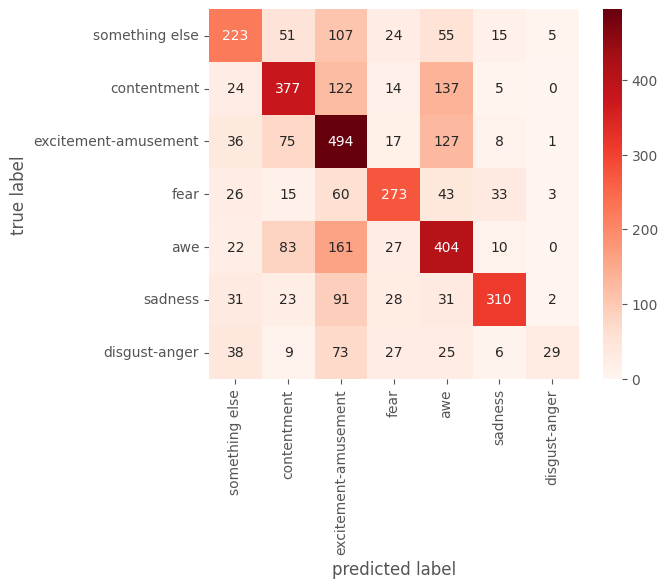

{'C': 0.7080725777960455, 'kernel': 'sigmoid'}


In [14]:
EXP1A = "SVC/COUNT"

if selected(EXP1A):

    model = search_factory(SVC(), distribution)
    exp = exp_run(EXP1A, model=model, transforms=[vectorizer], list_kwargs=[{"vect": default_vector("count")}])
    print(exp.model.best_params_)

Accuracy: 0.576
Precision: 0.600 | 0.585
Recall: 0.546 | 0.576
FPR: 0.073 | 0.088
F1-Score: 0.560 | 0.574


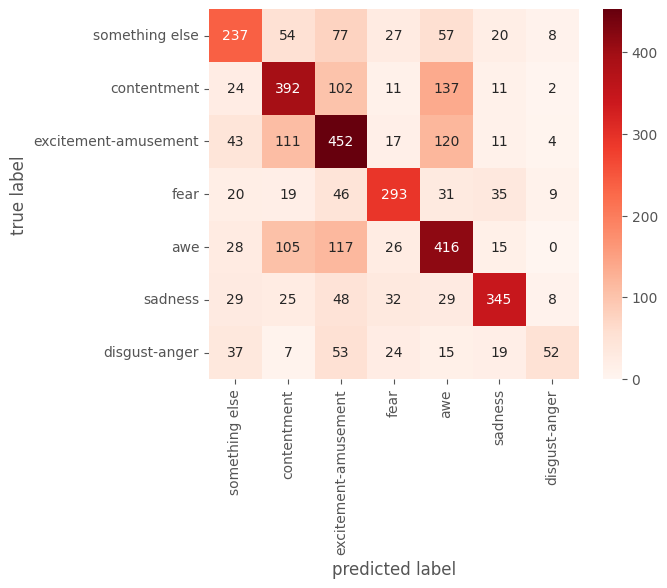

{'C': 0.8324426408004217, 'kernel': 'sigmoid'}


In [15]:
EXP1B = "SVC/TFIDF"

if selected(EXP1B):

    model = search_factory(SVC(), distribution)
    exp = exp_run(EXP1B, model=model, transforms=[vectorizer], list_kwargs=[{"vect": default_vector("tfidf")}])
    print(exp.model.best_params_)

Accuracy: 0.411
Precision: 0.434 | 0.422
Recall: 0.366 | 0.411
FPR: 0.102 | 0.122
F1-Score: 0.362 | 0.399


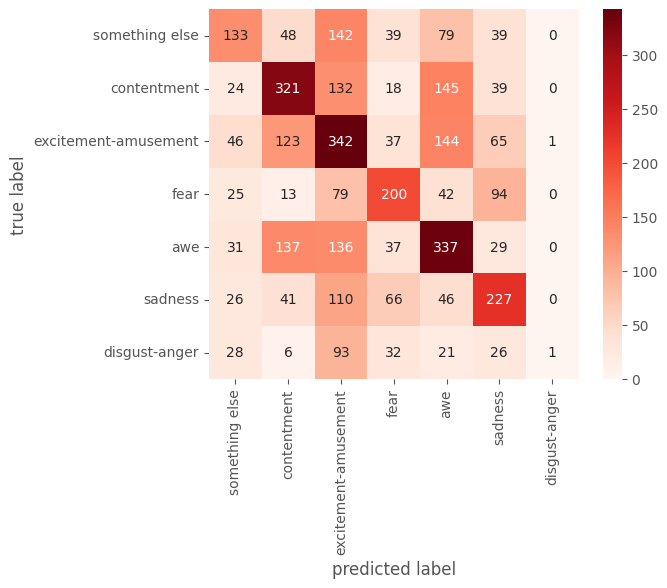

{'C': 0.5986584841970366, 'kernel': 'rbf'}


In [16]:
EXP1C = "SVC/D2V"

if selected(EXP1C):

    model = search_factory(SVC(), distribution)
    exp = exp_run(EXP1C, model=model, transforms=[d2v_transform])
    print(exp.model.best_params_)

***
## Logistic Regression with Random Search

In [17]:
# Hyperparameters to fine-tune
distribution = {"C": uniform(),
                "penalty": ["l1", "l2", "elasticnet"],
                "l1_ratio": uniform(), }

/home/computer_cat/miniconda3/envs/deep_learning/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/computer_cat/miniconda3/envs/deep_learning/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/computer_cat/miniconda3/envs/deep_learning/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/computer_cat/miniconda3/envs/deep_learning/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/computer_cat/miniconda3/envs/deep_learning/lib/python3.11/site-packages/sklearn/linear_model/_logist

Accuracy: 0.591
Precision: 0.605 | 0.595
Recall: 0.565 | 0.591
FPR: 0.070 | 0.082
F1-Score: 0.576 | 0.589


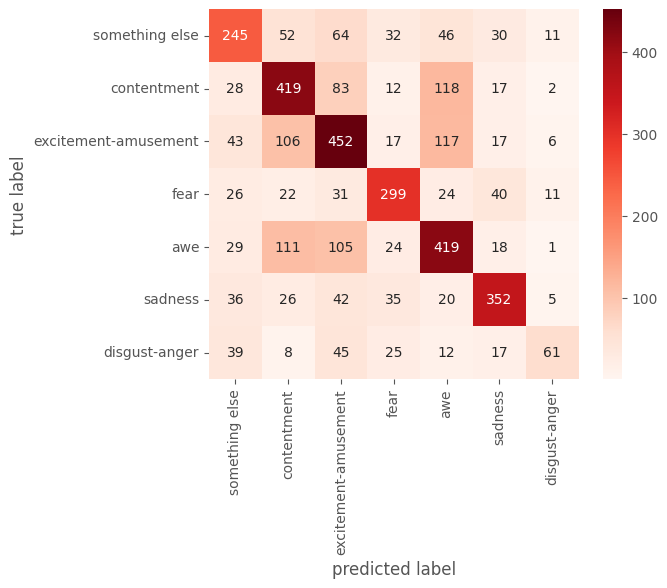

{'C': 0.3998609717152555, 'l1_ratio': 0.04666566321361543, 'penalty': 'elasticnet'}


In [18]:
EXP2A = "LOG/COUNT"

if selected(EXP2A):

    model = search_factory(LogisticRegression(solver="saga", random_state=SEED), distribution)
    exp = exp_run(EXP2A, model=model, transforms=[vectorizer], list_kwargs=[{"vect": default_vector("count")}])
    print(exp.model.best_params_)

/home/computer_cat/miniconda3/envs/deep_learning/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/computer_cat/miniconda3/envs/deep_learning/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/computer_cat/miniconda3/envs/deep_learning/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/computer_cat/miniconda3/envs/deep_learning/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/computer_cat/miniconda3/envs/deep_learning/lib/python3.11/site-packages/sklearn/linear

Accuracy: 0.588
Precision: 0.620 | 0.599
Recall: 0.555 | 0.588
FPR: 0.071 | 0.085
F1-Score: 0.568 | 0.585


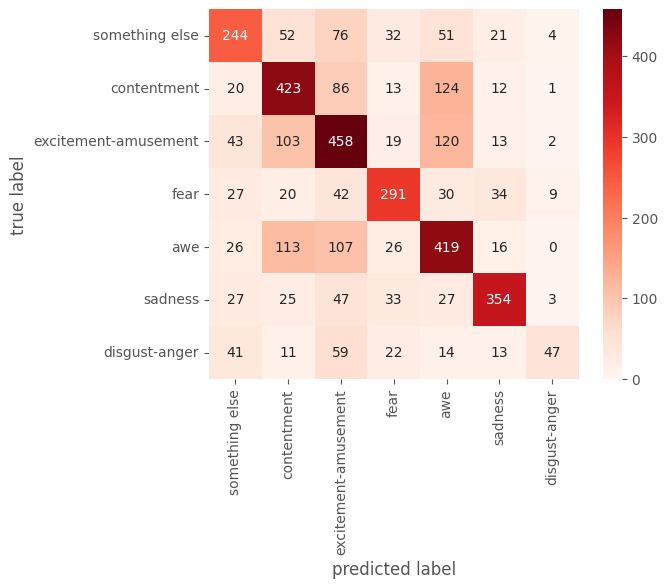

{'C': 0.7796910002727693, 'l1_ratio': 0.596850157946487, 'penalty': 'l2'}


In [19]:
EXP2B = "LOG/TFIDF"

if selected(EXP2B):
    
    model = search_factory(LogisticRegression(solver="saga", random_state=SEED), distribution)
    exp = exp_run(EXP2B, model=model, transforms=[vectorizer], list_kwargs=[{"vect": default_vector("tfidf")}])
    print(exp.model.best_params_)

/home/computer_cat/miniconda3/envs/deep_learning/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/computer_cat/miniconda3/envs/deep_learning/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/computer_cat/miniconda3/envs/deep_learning/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/computer_cat/miniconda3/envs/deep_learning/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/computer_cat/miniconda3/envs/deep_learning/lib/python3.11/site-packages/sklearn/linear

Accuracy: 0.406
Precision: 0.433 | 0.416
Recall: 0.370 | 0.406
FPR: 0.102 | 0.121
F1-Score: 0.366 | 0.396


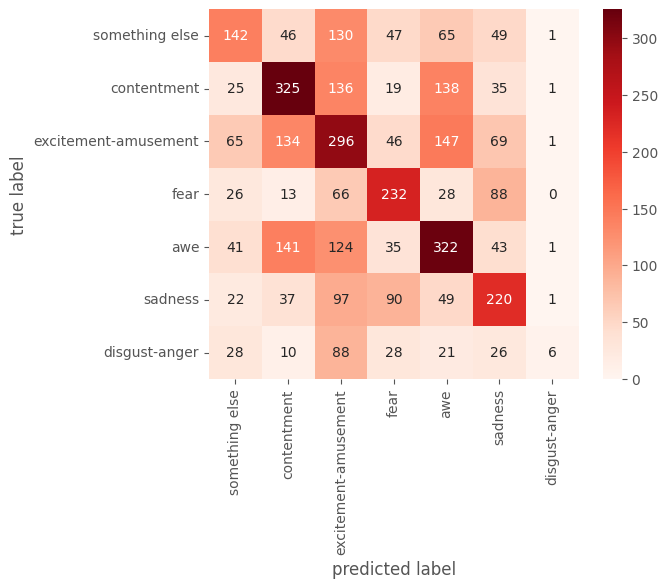

{'C': 0.6174815096277165, 'l1_ratio': 0.6116531604882809, 'penalty': 'l1'}


In [20]:
EXP2C = "LOG/D2V"

if selected(EXP2C):

    model = search_factory(LogisticRegression(solver="saga", random_state=SEED), distribution)
    exp = exp_run(EXP2C, model=model, transforms=[d2v_transform])
    print(exp.model.best_params_)

***
## Naive Bayes
### Multinomial NB

Accuracy: 0.597
Precision: 0.609 | 0.599
Recall: 0.565 | 0.597
FPR: 0.069 | 0.080
F1-Score: 0.569 | 0.590


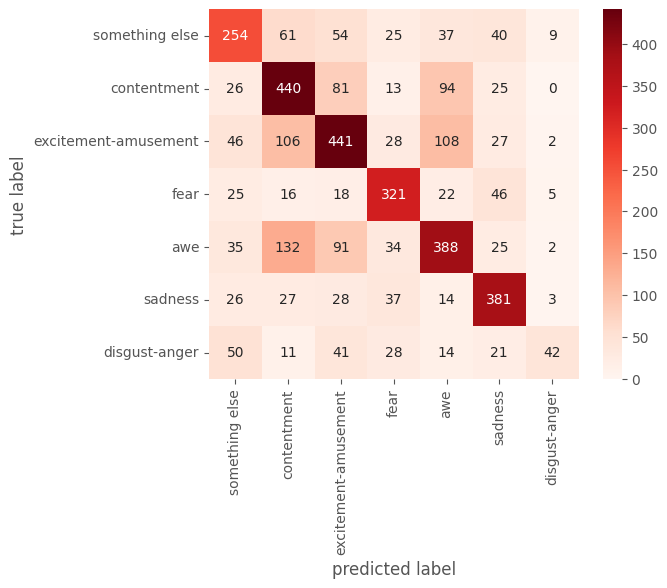

In [21]:
EXP3A = "MNB/COUNT"

if selected(EXP3A):
    exp_run(EXP3A, model=MultinomialNB(), transforms=[vectorizer], list_kwargs=[{"vect": default_vector("count")}])

Accuracy: 0.574
Precision: 0.662 | 0.611
Recall: 0.518 | 0.574
FPR: 0.074 | 0.091
F1-Score: 0.517 | 0.561


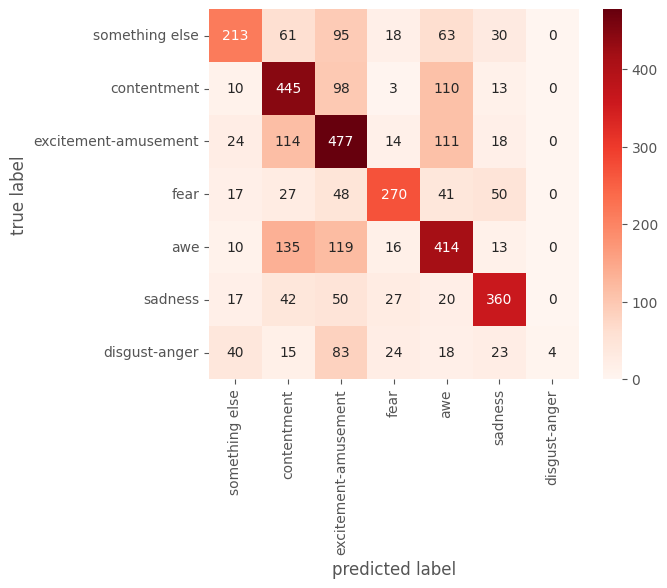

In [22]:
EXP3B = "MNB/TFIDF"

if selected(EXP3B):
    exp_run(EXP3B, model=MultinomialNB(), transforms=[vectorizer], list_kwargs=[{"vect": default_vector("tfidf")}])

### Complement NB

Accuracy: 0.608
Precision: 0.604 | 0.607
Recall: 0.587 | 0.608
FPR: 0.067 | 0.074
F1-Score: 0.588 | 0.603


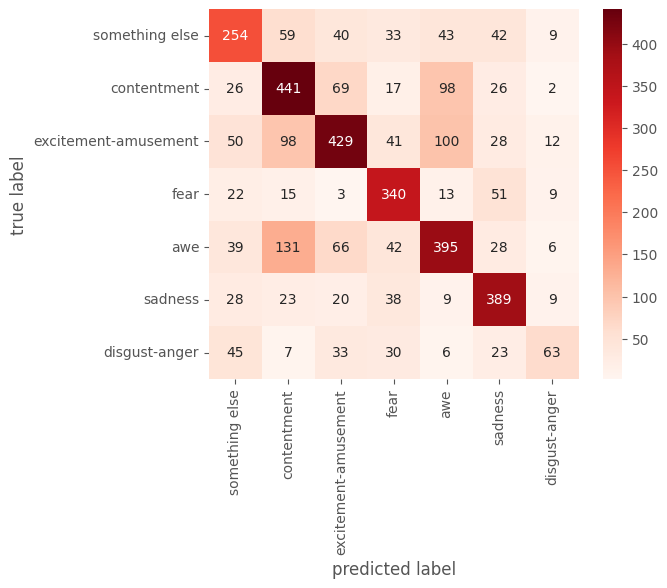

In [23]:
EXP4A = "COM/COUNT"

if selected(EXP4A):
    exp_run(EXP4A, model=ComplementNB(), transforms=[vectorizer], list_kwargs=[{"vect": default_vector("count")}])

Accuracy: 0.602
Precision: 0.597 | 0.602
Recall: 0.583 | 0.602
FPR: 0.068 | 0.076
F1-Score: 0.583 | 0.598


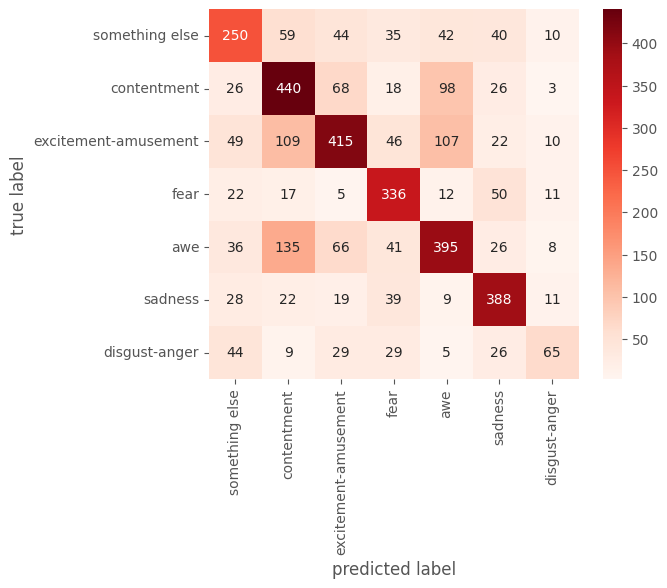

In [24]:
EXP4B = "COM/TFIDF"

if selected(EXP4B):
    exp_run(EXP4B, model=ComplementNB(), transforms=[vectorizer], list_kwargs=[{"vect": default_vector("tfidf")}])

***
## One Vs. Rest

For this, we will only run the best of the non-NN models.

Accuracy: 0.607
Precision: 0.624 | 0.610
Recall: 0.575 | 0.607
FPR: 0.067 | 0.078
F1-Score: 0.578 | 0.600


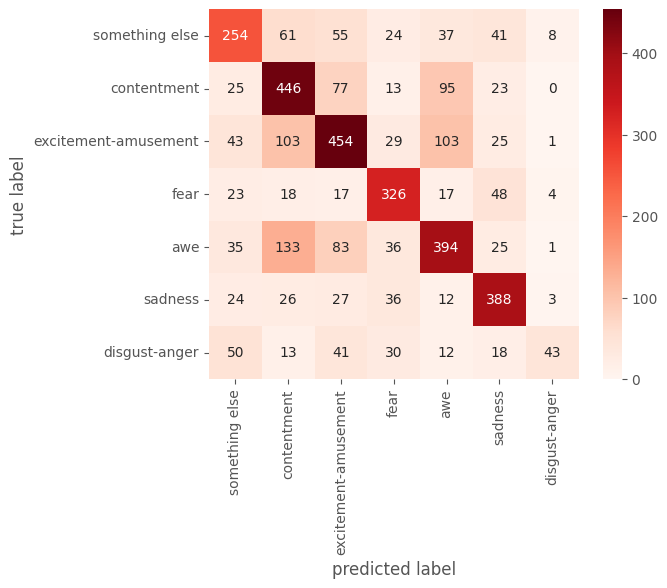

In [49]:
EXP5A = "ONE"

if selected(EXP5A):
    exp_run(EXP5A, model=OneVsRestClassifier(MultinomialNB()), transforms=[vectorizer], list_kwargs=[{"vect": default_vector("count")}])

***
## FFNN

In [26]:
def plot_loss(loss_record):

    df = pd.DataFrame(loss_record)
    df['training'] = df['epoch'] + df['step']
    sns.lineplot(data=df, x='training', y='loss')

In [27]:
CAT_TO_ID = {cat: i for i, cat in enumerate(DATA["emotion"].unique())}
ID_TO_CAT = {CAT_TO_ID[cat]: cat for cat in CAT_TO_ID}

def cat_transform(X, y, subset):
    zeroes = np.zeros((len(y), len(CAT_TO_ID)), dtype=np.float32)
    zeroes[np.array([range(len(y))]), np.array([CAT_TO_ID[cat] for cat in y])] = 1
    return X, zeroes

def to_emotions(y_true: np.ndarray, y_pred):
    return [ID_TO_CAT[i] for i in y_true.argmax(axis=1)], [ID_TO_CAT[i] for i in y_pred]

print(CAT_TO_ID)
print(ID_TO_CAT)

{'something else': 0, 'contentment': 1, 'excitement-amusement': 2, 'fear': 3, 'awe': 4, 'sadness': 5, 'disgust-anger': 6}
{0: 'something else', 1: 'contentment', 2: 'excitement-amusement', 3: 'fear', 4: 'awe', 5: 'sadness', 6: 'disgust-anger'}


In [28]:
# Sanity Check
test = list(CAT_TO_ID.keys())
print(test)
assert torch.equal(torch.eye(len(test), dtype=torch.float32), torch.from_numpy(cat_transform(None, test, "")[1]))

['something else', 'contentment', 'excitement-amusement', 'fear', 'awe', 'sadness', 'disgust-anger']


In [29]:
numpy_transform = lambda X, y, subset: (np.array(X).astype(np.float32), y)
scipy_transform = lambda X, y, subset: (X.toarray().astype(np.float32), y)

In [30]:
weights = [0,0,0,0,0,0,0]
for k in CAT_TO_ID:
    weights[CAT_TO_ID[k]] = 1 / DATA[DATA['split'] == 'TRAIN'].emotion.value_counts()[k]**0.5

In [31]:
# Sanity check
assert sorted(weights, reverse=True) == \
(1 / DATA[DATA['split'] == 'TRAIN'].emotion.value_counts()**0.5) \
.sort_values(ascending=False).to_list()

In [32]:
# The model for all FFNN experiments
steps_tfidf = [Linear(500, 250), 
               ReLU(),
               Dropout(p=0.25),
               Linear(250, 7), ]
            #    ReLU(),
            #    Dropout(p=0.2),
            #    Linear(150, 50),
            #    ReLU(),
            #    Dropout(p=0.2),
            #    Linear(50, 15),
            #    ReLU(),
            #    Dropout(p=0.2),
            #    Linear(15, 7)]

steps_d2v = [Linear(15, 15),
             Dropout(p=0.2),
             Softmax(),
             Dropout(p=0.2),
             Linear(15, 7), ]

sampler = WeightedRandomSampler(weights,
                                len(DATA[DATA['split'] == "TRAIN"]),
                                replacement=True)

config = {"steps": None,
          "lr": 1E-7,
          "epochs": 10,
          "batch_size": 4,
          "binary": False, 
          "sampler": None, }

In [33]:
EXP6A = "FFNN/D2V"

if selected(EXP6A):

    config['steps'] = steps_d2v

    exp = exp_run(EXP6A, model=FFNN(**config), 
                  transforms=[d2v_transform, cat_transform, numpy_transform], 
                  verbose=False, post=to_emotions)
    plot_loss(exp.model.loss_record)

In [34]:
EXP6B = "FFNN/D2VO"

if selected(EXP6B):

    config['steps'] = steps_d2v

    exp = exp_run(EXP6B, model=FFNN(**config), transforms=[d2v_transform, cat_transform, numpy_transform], verbose=False, post=to_emotions)
    plot_loss(exp.model.loss_record)

In [35]:
EXP6C = "FFNN/TFIDFO"

if selected(EXP6C):

    config['steps'] = steps_tfidf

    exp = exp_run(EXP6C, model=FFNN(**config), 
                  transforms=[vectorizer, cat_transform, scipy_transform], 
                  list_kwargs=[{"vect": default_vector("tfidf", 500)}, {}, {}], 
                  verbose=False, post=to_emotions)
    plot_loss(exp.model.loss_record)

---

## LSTM

In [36]:
EXP7A = "LSTM/W2VO"

if selected(EXP7A):

    def to_emotions(y_true, y_pred):
        return [ID_TO_CAT[i] for i in y_true], [ID_TO_CAT[i] for i in y_pred]

    sampler = WeightedRandomSampler(weights,
                                    len(DATA[DATA['split'] == "TRAIN"]),
                                    replacement=True)
    
    in_linear = [Linear(300, 150),
                 ReLU(),
                 Dropout(0.2), ]
    
    out_linear = [ReLU(),
                  Linear(90, 40),
                  ReLU(),
                  Linear(40, 7),]

    config = {"input_size": 150,
              "hidden_size": 90,
              "num_layers": 10,
              "num_classes": 7,
              "lr": 1E-7,
              "epochs": 10,
              "batch_size": 16,
              "in_linear": in_linear,
              "out_linear": out_linear,
              "binary": False, 
              "sampler": None, }

    exp = exp_run(EXP6C, model=LSTM(**config), 
                  transforms=[w2v_transform, cat_transform, numpy_transform], 
                  verbose=False, post=to_emotions)
    plot_loss(exp.model.loss_record)

***
## Results

In [38]:
results_df = pd.DataFrame(RESULTS)
results_df["ratio"] = results_df["recall"] / results_df["fpr"]
results_df

ValueError: All arrays must be of the same length

In [41]:
for key in RESULTS:
    print(key, len(RESULTS[key]))

experiment 11
accuracy 11
precision 11
recall 11
fpr 11
f1_score 0
precision_weighted 11
recall_weighted 11
fpr_weighted 11
f1_score_weighted 11
comments 11


In [ ]:
DATA['emotion'].value_counts().describe()

count       7.000000
mean     2714.285714
std       951.446918
min      1035.000000
25%      2333.500000
50%      2579.000000
75%      3464.000000
max      3791.000000
Name: count, dtype: float64

In [ ]:
grid = sns.FacetGrid(data=results_df.drop(columns=["comments"]).melt(id_vars=["experiment"]),
                     col="variable", col_wrap=3, sharey=False)
grid.map_dataframe(sns.barplot, x="experiment", y="value", hue="experiment")


ValueError: Number of rows must be a positive integer, not 0

<Figure size 900x0 with 0 Axes>